In [1]:
import pickle as cp
import numpy as np
import matplotlib.pyplot as plt

# load data for white wine
X, y = cp.load(open('winequality-white.pickle', 'rb'), encoding = 'latin1')


In [2]:
# separate train and test data (80% vs 20%)
# The y-values are integers between 3 and 9 indicating the quality of the wine
N, D = X.shape

N_train = int(0.8 * N)
N_test = N - N_train

X_train = X[:N_train]
y_train = y[:N_train]

X_test = X[N_train:]
y_test = y[N_train:]


[3. 4. 5. 6. 7. 8. 9.]
[  14  129 1164 1772  692  144    3]


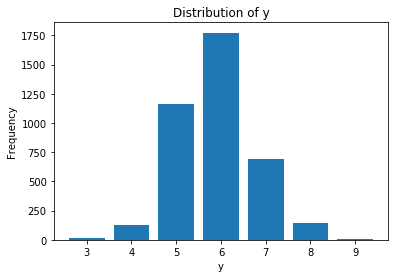

In [3]:
# Handin 1
# Make a bar chart showing the distribution of y-values in the training set
# find y possible values
unique, counts = np.unique(y_train, return_counts=True)
print(unique)
print(counts)

plt.bar(unique, counts, align='center')

plt.ylabel('Frequency')
plt.xlabel('y')
plt.title('Distribution of y')

plt.show()

In [4]:
# Handin 2
# Report  the  mean  squared  error,  i.e.,  the  average  of  the  squared  residuals,
# using  this simplest  of  predictors  on  the  training  and  test  data.

# Define a function returning the Mean Squared Error
def MSE(y_actual, y_predict):
    return np.mean((y_predict - y_actual)**2)

y_prediction = np.mean(y_train)
# print("y_train_mean = %.3f" % y_prediction)

mse_train = MSE(y_train, y_prediction)
mse_test = MSE(y_test, y_prediction)
print("Mean Squared Error on Training Data: %f" %mse_train)
print("Mean Squared Error on Test Data: %f" %mse_test)

# from sklearn.metrics import mean_squared_error
# y_pred = np.full((1, len(y_test)), y_prediction)
# print("Mean Squared Error on Test Data: %f" %mean_squared_error(y_test, y_pred[0, :]))


Mean Squared Error on Training Data: 0.776777
Mean Squared Error on Test Data: 0.813857


In [5]:
# Handin 3
# Report the mean squared error using the linear model on the training and test data
from sklearn.metrics import mean_squared_error

def normalize(train_data: np.ndarray,
              test_data: np.array) -> tuple:
    norm_train_data = np.ones((N_train, D + 1))
    norm_test_data = np.ones((N_test, D + 1))
    for j in range(D) :
        avg = np.mean(train_data[:, j])
        std = np.std(train_data[:, j])
        norm_train_data[:, j + 1] = (train_data[:, j] - avg) / std
        norm_test_data[:, j + 1] = (test_data[:, j] - avg) / std
    
    return norm_train_data, norm_test_data
        

def calculate_weights(train_data: np.ndarray,
                      train_out: np.ndarray) -> np.ndarray:
    train_data_transposed = train_data.T
    return (np.linalg.inv(train_data_transposed.dot(train_data))).dot(train_data_transposed).dot(train_out) 

def predict(data_vector: np.ndarray,
            w: np.ndarray) -> np.ndarray:
    return data_vector.dot(w)

X_train_norm, X_test_norm = normalize(X_train, X_test)

w = calculate_weights(X_train_norm, y_train)

y_pred_train = predict(X_train_norm, w)
y_pred_test = predict(X_test_norm, w)

print("Mean Squared Error on Train Data: %f" %mean_squared_error(y_train, y_pred_train))
print("Mean Squared Error on Test Data: %f" %mean_squared_error(y_test, y_pred_test))


Mean Squared Error on Train Data: 0.564000
Mean Squared Error on Test Data: 0.560729


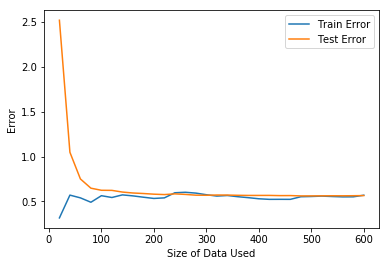

In [6]:
# Handin 4
# Report the learning curves plot
# Plot the training error and test error as a function of the size of the dataset used for training
dataset_sizes = []
train_errs = []
test_errs = []

i = 20
while i <= 600 :
    X_train_new = X_train_norm[:i]
    y_train_new = y_train[:i]
    
    w = calculate_weights(X_train_new, y_train_new)
    
    y_pred_train = predict(X_train_new, w)
    y_pred_test = predict(X_test_norm, w)
    
    train_errs.append(MSE(y_train_new, y_pred_train))
    test_errs.append(MSE(y_test, y_pred_test))
    
    dataset_sizes.append(i)
    
    i += 20


plt.plot(dataset_sizes, train_errs, label = "Train Error") 
plt.plot(dataset_sizes, test_errs, label = "Test Error")

plt.legend(loc=1)

plt.xlabel('Size of Data Used')
plt.ylabel('Error')

plt.show()


In [12]:
# Polynomial Basis Expansion with Ridge and Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

N_train, D = X_train.shape

N_train_new = int(0.8 * N_train)
N_validation = N_train - N_train_new

X_train_new = X_train[:N_train_new]
y_train_new = y_train[:N_train_new]

X_validation = X_train[N_train_new:N_train]
y_validation = y_train[N_train_new:N_train]


lambdas = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 1e+2, 1e+3, 1e+4, 1e+5]
degrees = [1, 2, 3, 4]

d_optimal = degrees[0]
lambda_optimal = lambdas[0]
mse_optimal = 10
mse_train_optimal = 0

# find Ridge parameters
for d in degrees :
    for lam in lambdas :
        # ridge = make_pipeline(PolynomialFeatures(d), Ridge(alpha = lam))
        ridge = Pipeline([('poly', PolynomialFeatures(d)), ('scale', StandardScaler()), 
                          ('ridge', Ridge(alpha = lam, fit_intercept = True))])
        ridge.fit(X_train_new, y_train_new)
        mse_train = mean_squared_error(ridge.predict(X_train_new), y_train_new)
        mse_valid = mean_squared_error(ridge.predict(X_validation), y_validation)
        if mse_valid < mse_optimal :
            mse_optimal = mse_valid
            mse_train_optimal = mse_train
            d_optimal = d
            lambda_optimal = lam

print("Optimal HyperParameters for Ridge Regression:")
print("Polynomial degree: %d Lambda: %f" % (d_optimal, lambda_optimal))
print("Mean Squared Error on Train Data: %f" %mse_train_optimal)
print("Mean Squared Error on Validation Data: %f\n" %mse_optimal)

# run model on full train/test data
ridge = Pipeline([('poly', PolynomialFeatures(d_optimal)), ('scale', StandardScaler()), 
                  ('ridge', Ridge(alpha = lambda_optimal, fit_intercept = True))])
ridge.fit(X_train, y_train)
print("Mean Squared Error on Train Data: %f" %mean_squared_error(ridge.predict(X_train), y_train))
print("Mean Squared Error on Test Data: %f" %mean_squared_error(ridge.predict(X_test), y_test))

# with our previous impl - deg = 1
#Mean Squared Error on Train Data: 0.571561
#Mean Squared Error on Test Data: 0.567391


Optimal HyperParameters for Ridge Regression:
Polynomial degree: 4 Lambda: 10.000000
Mean Squared Error on Train Data: 0.447976
Mean Squared Error on Validation Data: 0.495299

Mean Squared Error on Train Data: 0.450439
Mean Squared Error on Test Data: 0.586035


In [14]:
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings("ignore", category=Warning)

d_optimal = degrees[0]
lambda_optimal = lambdas[0]
mse_optimal = 10
mse_train_optimal = 0

# find Ridge parameters
for d in degrees :
    for lam in lambdas :
        # ridge = make_pipeline(PolynomialFeatures(d), Ridge(alpha = lam))
        lasso = Pipeline([('poly', PolynomialFeatures(d)), ('scale', StandardScaler()), 
                          ('ridge', Lasso(alpha = lam, fit_intercept = True))])
        lasso.fit(X_train_new, y_train_new)
        mse_train = mean_squared_error(lasso.predict(X_train_new), y_train_new)
        mse_valid = mean_squared_error(lasso.predict(X_validation), y_validation)
        if mse_valid < mse_optimal :
            mse_optimal = mse_valid
            mse_train_optimal = mse_train
            d_optimal = d
            lambda_optimal = lam

print("Optimal HyperParameters for Lasso Regression:")
print("Polynomial degree: %d Lambda: %f" % (d_optimal, lambda_optimal))
print("Mean Squared Error on Train Data: %f" %mse_train_optimal)
print("Mean Squared Error on Validation Data: %f\n" %mse_optimal)

# run model on full train/test data
lasso = Pipeline([('poly', PolynomialFeatures(d_optimal)), ('scale', StandardScaler()), 
                  ('ridge', Lasso(alpha = lambda_optimal, fit_intercept = True))])
lasso.fit(X_train, y_train)
print("Mean Squared Error on Train Data: %f" %mean_squared_error(lasso.predict(X_train), y_train))
print("Mean Squared Error on Test Data: %f" %mean_squared_error(lasso.predict(X_test), y_test))

# with our previous impl - deg = 1
#Mean Squared Error on Train Data: 0.571561
#Mean Squared Error on Test Data: 0.567391



Optimal HyperParameters for Lasso Regression:
Polynomial degree: 4 Lambda: 0.001000
Mean Squared Error on Train Data: 0.473102
Mean Squared Error on Validation Data: 0.500467

Mean Squared Error on Train Data: 0.476254
Mean Squared Error on Test Data: 0.533768
